In [1]:
import glob
import numpy as np
import scipy as sp
import einops as eo
import matplotlib.pyplot as plt
import math
import plotly.graph_objects as go
from scipy.spatial.transform import Rotation
import magpylib as magpy
import os
import pandas as pd
from datetime import timedelta
import sys
from datetime import datetime

print(sys.executable)

M0 = 1480 #mT
shape = [5*25.4/16, 25.4/8] #radius and height
x0 = np.array([0,0,10, 0,0,1])

c:\Users\Brandon Nguyen\AppData\Local\Programs\Python\Python312\python.exe


In [2]:
def B_dipole(position, rotation, M0, shape):
    R = np.sqrt(np.sum(position**2, axis=1))
    B = (M0 * (shape[0]) ** 2 * shape[1] / (16)) * (
        (
            3
            * position
            / R[:, np.newaxis] ** 5
            * (eo.einsum(position, rotation, "sensor dim,  dim -> sensor"))[
                :, np.newaxis
            ]
        )
        - rotation[np.newaxis, :] / (R[:, np.newaxis] ** 3)
    )
    return B


def getField_dipole(x, positions, M0, shape):
    position = x[:3]
    axis = x[3:]
    return B_dipole(positions - position, axis, M0, shape)


def getField_dipole_fixed(x, positions, M0, shape):
    position = x[:3]
    axis = x[3:]
    return B_dipole(positions - position, axis, M0, shape)


def cost_dipole(x, B, positions, M0, shape):
    diff = getField_dipole(x, positions, M0, shape) - B
    return np.sum((diff) ** 2)


def getField_cylinder(x, positions, M0, shape):
    B=magpy.getB(
        sources="Cylinder",
        position=x[:3],
        orientation=Rotation.align_vectors(x[3:], np.array([0, 0, 1]))[0],
        observers=positions,
        dimension=shape,
        polarization=(0, 0, M0),
    )
    return B

def cost_cylinder(x, B, positions, M0, shape):
    diff = getField_cylinder(x, positions, M0, shape) - B
    return np.sum((diff) ** 2)

def minimize(x0, B, positions, M0, shape, *args):
    #print("Starting mimimization")
    b_args = (B, positions, M0, shape)
    cons = [{"type": "eq", "fun": lambda x: x[3] ** 2 + x[4] ** 2 + x[5] ** 2 - 1}]
    bounds = [(-100, 100), (-100, 100), (0, 100), (-1, 1), (-1, 1), (-1, 1)]
    res = sp.optimize.minimize(
        fun=cost_dipole, x0=x0, args=b_args, tol=1e-100, constraints=cons, bounds=bounds, *args
    ).x  
    #print(f"Finished mimimization with shape {b_args[3]} at {res}")
    return res

def circle_radius(x1, y1, x2, y2, x3, y3):
    # Calculate lengths of sides of the triangle formed by the three points
    a = math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
    b = math.sqrt((x3 - x2) ** 2 + (y3 - y2) ** 2)
    c = math.sqrt((x3 - x1) ** 2 + (y3 - y1) ** 2)

    # Calculate the semi-perimeter of the triangle
    s = (a + b + c) / 2

    # Calculate the area of the triangle using Heron's formula
    area = math.sqrt(s * (s - a) * (s - b) * (s - c))

    # Calculate the radius of the circle using the formula: radius = (abc) / (4 * area)
    radius = (a * b * c) / (4 * area)
    
    return radius

def comparison_plot(locact, locpred, axis, relative):

    if axis == 'x':
        ax = 0
    elif axis == 'y':
        ax = 1
    else:
        ax = 2

    index = list(range(len(locact[:,ax])))
    act = locact[:, ax]
    pred = locpred[:, ax]

    rel = ''

    if relative==True:
        act = [x - locact[0, ax] for x in locact[:, ax]]
        pred = [x - locpred[0, ax] for x in locpred[:, ax]]
        rel = ' (Relative)'

    # Plotting
    plt.figure(figsize=(8, 6))
    plt.scatter(index, pred, label='Predicted' + rel)
    plt.scatter(index, act, label='Actual' + rel)
    plt.xlabel('Time Passed (s)')
    plt.ylabel(axis + '-component')
    plt.title('Comparison of '+axis+ ' Location' + rel+ ': Predicted vs Actual')
    plt.legend()
    plt.grid(True)
    plt.show()

    return

def comp_plot3D(locact, locpred, xact, yact, axis, relative):

    if axis == 'x':
        ax = 0
    elif axis == 'y':
        ax = 1
    else:
        ax = 2

    index = list(range(len(locact[:,ax])))
    act = locact[:, ax]
    pred = locpred[:, ax]

    rel = ''

    if relative==True:
        act = [x - locact[0, ax] for x in locact[:, ax]]
        pred = [x - locpred[0, ax] for x in locpred[:, ax]]
        rel = ' (Relative)'

    fig = go.Figure(data=[
        go.Scatter3d(x=xact, y=yact, z=pred, name='Predicted' + rel),
        go.Scatter3d(x=xact, y=yact, z=act, name='Actual' + rel)])
    fig.show()

    return

def displacement_plot(actual, predicted):

    dispx = np.array(predicted[:,0]-predicted[:,0][0])
    dispy = np.array(predicted[:,1]-predicted[:,1][0])
    dispz = np.array(predicted[:,2]-predicted[:,2][0])
    disp = np.sqrt(dispx**2+dispy**2+dispz**2)
    actdispx = np.array(actual[:,0]-actual[:,0][0])
    actdispy = np.array(actual[:,1]-actual[:,1][0])
    actdispz = np.array(actual[:,2]-actual[:,2][0])
    actdisp = np.sqrt(actdispx**2+actdispy**2+actdispz**2)

    plt.figure(figsize=(8, 6))
    plt.scatter(list(range(len(disp))), disp, label='Predicted Displacement')
    plt.scatter(list(range(len(actdisp))), actdisp, label='Actual Displacement')
    plt.xlabel('Time Passed (s)')
    plt.ylabel('Displacement (mm)')
    plt.title('Magnet Displacement')
    plt.legend()
    plt.grid(True)
    plt.show()

    return

# Function to convert HHMMSS to seconds
def time_to_seconds(time_str):
    hours = int(time_str[:2])
    minutes = int(time_str[2:4])
    seconds = int(time_str[4:6])
    return hours * 3600 + minutes * 60 + seconds

def time_to_secondsdf(time_value):
    return time_value.hour * 3600 + time_value.minute * 60 + time_value.second + time_value.microsecond / 1e6

# Function to extract the timestamp part from the file path
def extract_timestamp(file_path):
    # Extract the filename from the file path (without the extension)
    filename = os.path.basename(file_path).replace('.npz', '')
    
    # Split the filename into date, time, and millisecond parts
    date_part = filename.split('-')[0]  # Extracting the 'YYYYMMDD' part
    time_part = filename.split('-')[1]  # Extracting the 'HHMMSS' part
    millisecond_part = filename.split('-')[2]  # Extracting the millisecond part
    
    # Combine date, time, and milliseconds into a full timestamp string
    full_datetime_str = f"{date_part} {time_part}.{millisecond_part}"
    
    # Create a datetime object
    full_datetime = datetime.strptime(full_datetime_str, "%Y%m%d %H%M%S.%f")
    
    return full_datetime

def importfitting(folder):

    file_list = sorted(glob.glob(f'{folder}/*.npz'))
    #print(file_list)
    data = np.load(file_list[0])
    pos = data['pos'][0]
    timestamps = []

    locpred = [np.array([0,0,0])]
    anglepred = [np.array([0,0,0])]
    Bstdev = [np.array(pos)]
    for x in range(len(file_list)):
        data = np.load(file_list[x])
        mags = data['mags']
        pos = data['pos'][0]
        B = np.mean(mags, axis=0)
        mags_stdev = np.std(mags, axis=0)
        timestamps.append(extract_timestamp(file_list[x]))

        x_res = minimize(x0, B, pos, M0, shape)
        locpred = np.append(locpred, [x_res[0:3]], axis=0)
        anglepred = np.append(anglepred, [x_res[3:6]], axis=0)
        Bstdev = np.append(Bstdev, [mags_stdev], axis=0)
    locpred = np.delete(locpred, 0, axis=0)
    anglepred = np.delete(anglepred, 0, axis=0)
    Bstdev = np.delete(Bstdev, 0 ,axis=0)

    return pos, mags, locpred, anglepred, Bstdev, timestamps

def actualangle(xind, yind, xscal, xcon, yscal, ycon, isoff):

    angact = [np.array([0, 0, 0])]
    for y in range(yind):
        for x in range(xind):
            R = Rotation.from_euler('ZYX' ,np.array([0, yscal*y-ycon, xscal*x-xcon]), degrees=True)
            norm = np.array([[0, 0, 1]])
            rotated = R.apply(norm, inverse=False)[0]
            #add = np.array([np.sin(np.deg2rad(2*y-4)), -np.sin(np.deg2rad(2*x-4)), np.cos(np.deg2rad(2*y-4))*np.cos(np.deg2rad(2*x-4))])
            angact = np.append(angact, [rotated], axis=0)
    angact = np.delete(angact, 0, axis=0)
    locact = angact*isoff

    return angact, locact

In [3]:
folder = os.path.join('..', './MLX09302024_D52N52_gammaknife')
pos, mags, locpred, anglepred, Bstdev, timestamps = importfitting(folder)
np.append(locpred, anglepred, axis=1)
#print(timeelapsed)
print(len(locpred))

656


In [4]:
locpred
# Specify the file path where you want to save the list
file_path = 'MLX09302024_gk_locpred.txt'

# Convert the list to a DataFrame
df = pd.DataFrame(locpred)

# Save the DataFrame to a CSV file
df.to_csv(file_path, index=False, header=['x', 'y', 'z'])  # Set index and header to False if not needed

print(f"List saved to {file_path}")

List saved to MLX09302024_gk_locpred.txt


In [5]:
timestamps
# Define the incorrect and correct times
incorrect_time = pd.to_datetime("6:01:05").time()  # Incorrect time (6:01)
correct_time = pd.to_datetime("14:24:00").time()   # Correct time (2:24)

# Calculate the time difference
time_difference = timedelta(hours=correct_time.hour, minutes=correct_time.minute, seconds=correct_time.second) - \
                  timedelta(hours=incorrect_time.hour, minutes=incorrect_time.minute, seconds=incorrect_time.second)

# Apply the time difference to correct the list of incorrect timestamps
corrected_timestamps = [t + time_difference for t in timestamps]
print(timestamps)
corrected_timestamps

[datetime.datetime(2024, 9, 30, 6, 0, 33, 60790), datetime.datetime(2024, 9, 30, 6, 0, 38, 4075), datetime.datetime(2024, 9, 30, 6, 0, 38, 522044), datetime.datetime(2024, 9, 30, 6, 0, 39, 70976), datetime.datetime(2024, 9, 30, 6, 0, 39, 573478), datetime.datetime(2024, 9, 30, 6, 0, 40, 77044), datetime.datetime(2024, 9, 30, 6, 0, 40, 581478), datetime.datetime(2024, 9, 30, 6, 0, 41, 84778), datetime.datetime(2024, 9, 30, 6, 0, 41, 590597), datetime.datetime(2024, 9, 30, 6, 0, 42, 94302), datetime.datetime(2024, 9, 30, 6, 0, 42, 653648), datetime.datetime(2024, 9, 30, 6, 0, 43, 157683), datetime.datetime(2024, 9, 30, 6, 0, 43, 660982), datetime.datetime(2024, 9, 30, 6, 0, 44, 164220), datetime.datetime(2024, 9, 30, 6, 0, 44, 669206), datetime.datetime(2024, 9, 30, 6, 0, 45, 173355), datetime.datetime(2024, 9, 30, 6, 0, 45, 854559), datetime.datetime(2024, 9, 30, 6, 0, 46, 360151), datetime.datetime(2024, 9, 30, 6, 0, 46, 864468), datetime.datetime(2024, 9, 30, 6, 0, 47, 371027), dateti

[datetime.datetime(2024, 9, 30, 14, 23, 28, 60790),
 datetime.datetime(2024, 9, 30, 14, 23, 33, 4075),
 datetime.datetime(2024, 9, 30, 14, 23, 33, 522044),
 datetime.datetime(2024, 9, 30, 14, 23, 34, 70976),
 datetime.datetime(2024, 9, 30, 14, 23, 34, 573478),
 datetime.datetime(2024, 9, 30, 14, 23, 35, 77044),
 datetime.datetime(2024, 9, 30, 14, 23, 35, 581478),
 datetime.datetime(2024, 9, 30, 14, 23, 36, 84778),
 datetime.datetime(2024, 9, 30, 14, 23, 36, 590597),
 datetime.datetime(2024, 9, 30, 14, 23, 37, 94302),
 datetime.datetime(2024, 9, 30, 14, 23, 37, 653648),
 datetime.datetime(2024, 9, 30, 14, 23, 38, 157683),
 datetime.datetime(2024, 9, 30, 14, 23, 38, 660982),
 datetime.datetime(2024, 9, 30, 14, 23, 39, 164220),
 datetime.datetime(2024, 9, 30, 14, 23, 39, 669206),
 datetime.datetime(2024, 9, 30, 14, 23, 40, 173355),
 datetime.datetime(2024, 9, 30, 14, 23, 40, 854559),
 datetime.datetime(2024, 9, 30, 14, 23, 41, 360151),
 datetime.datetime(2024, 9, 30, 14, 23, 41, 864468),


In [6]:
file_list = sorted(glob.glob(f'{folder}/*.npz'))
len(file_list)
data = np.load(file_list[0])
pos = data['pos'][0]

all_mags = [np.array([0,0,0])]
for x in range(len(file_list)):
    data = np.load(file_list[x])
    mags = data['mags']
    all_mags = np.append(all_mags, mags[0], axis=0)
    pos = data['pos'][0]
    B = np.mean(mags, axis=0)
    mags_stdev = np.std(mags, axis=0)
all_mags = np.delete(all_mags, 0, axis=0)

print(all_mags)
bx = all_mags[:,0]
by = all_mags[:,1]
bz = all_mags[:,2]

print(bx)
len(bx)

[[-0.0843    0.2043    1.37456 ]
 [ 0.2532    0.1842    1.341648]
 [ 0.5025    0.1014    1.100132]
 ...
 [ 0.1632   -0.5835    0.317504]
 [ 0.2481   -0.5169    0.226512]
 [ 0.2916   -0.402     0.13068 ]]
[-0.0843  0.2532  0.5025 ...  0.1632  0.2481  0.2916]


10496

In [7]:
bx7 = []
by7 = []
bz7 = []
for x in range(len(bx)):
    if x % 16 == 7:
        bx7.append(bx[x])
        by7.append(by[x])
        bz7.append(bz[x])
print(bx7)
print(by7)
print(bz7)
print(pos)

[0.6033, 0.6051, 0.6056999999999999, 0.6033, 0.6039, 0.6033, 0.603, 0.6039, 0.6045, 0.6033, 0.6036, 0.6036, 0.6048, 0.6051, 0.6042, 0.6042, 0.6026999999999999, 0.6042, 0.6033, 0.6042, 0.6039, 0.6026999999999999, 0.603, 0.6039, 0.6042, 0.6039, 0.6048, 0.603, 0.6039, 0.6039, 0.6036, 0.6051, 0.6036, 0.6051, 0.6026999999999999, 0.603, 0.6036, 0.6036, 0.6042, 0.603, 0.6039, 0.6039, 0.603, 0.6036, 0.6042, 0.6033, 0.6026999999999999, 0.6018, 0.6026999999999999, 0.6045, 0.6036, 0.6039, 0.6033, 0.6039, 0.6051, 0.6048, 0.6036, 0.6033, 0.6026999999999999, 0.6023999999999999, 0.6036, 0.6036, 0.6036, 0.6042, 0.6036, 0.6039, 0.6042, 0.6042, 0.6042, 0.6033, 0.6042, 0.603, 0.6026999999999999, 0.6023999999999999, 0.6039, 0.6042, 0.6023999999999999, 0.6026999999999999, 0.603, 0.6042, 0.6042, 0.6039, 0.6053999999999999, 0.603, 0.6018, 0.603, 0.6042, 0.6045, 0.6051, 0.6051, 0.6026999999999999, 0.6039, 0.6042, 0.6039, 0.6051, 0.6051, 0.6033, 0.6051, 0.6051, 0.603, 0.6036, 0.6045, 0.6039, 0.6051, 0.6048, 0.

In [8]:
index = np.array(range(len(bx7)))
measuredbx = go.Scatter(x=index, y=bx7, mode='markers')
layoutbx = go.Layout(title='b_x over time')
figbx = go.Figure(data=[measuredbx], layout=layoutbx)
figbx.update_yaxes(scaleanchor='y')
figbx.update_layout(
    xaxis_title="Index",
    yaxis_title="b_x [mT]"
)
figbx.show()

In [9]:
measuredby = go.Scatter(x=index, y=by7, mode='markers')
layoutby = go.Layout(title='b_y over time')
figby = go.Figure(data=[measuredby], layout=layoutby)
figby.update_yaxes(scaleanchor='y')
figby.update_layout(
    xaxis_title="Index",
    yaxis_title="b_y [mT]"
)
figby.show()

In [10]:
measuredbz = go.Scatter(x=index, y=bz7, mode='markers')
layoutbz = go.Layout(title='b_z over time')
figbz = go.Figure(data=[measuredbz], layout=layoutbz)
figbz.update_yaxes(scaleanchor='y')
figbz.update_layout(
    xaxis_title="Index",
    yaxis_title="b_z [mT]"
)
figbz.show()

In [11]:
# Specify the Excel file name (replace with your actual file name)
file = 'Shift_data_09302024gk.txt'

# Create the full file path
file_path = os.path.join('..', file)

# Read the Excel file into a pandas DataFrame
df = pd.read_csv(file_path, delimiter=',', na_values="        NaN")

df.dropna(inplace=True)
df[['X', 'Y', 'Z', 'Displacement [mm]']] = df[['X', 'Y', 'Z', 'Displacement [mm]']].apply(pd.to_numeric,errors='coerce')
df['Time'] = pd.to_datetime(df['Time'], format='%Y-%m-%dT%H:%M:%S.%f')
df['datetime'] = df.loc[0:,'Time'].dt.time


print(df)
hdmm_time = df['Time']
hdmm_disp = df.loc[0:,'Displacement [mm]']
hdmm_x = df.loc[0:, 'X']
hdmm_y = df.loc[0:, 'Y']
hdmm_z = df.loc[0:, 'Z']
print(hdmm_time)

                       Time     X     Y     Z  Displacement [mm]  \
6   2024-09-30 14:21:38.224 -0.00 -0.00 -0.02               0.02   
7   2024-09-30 14:21:38.724 -0.02 -0.01  0.01               0.02   
8   2024-09-30 14:21:39.240 -0.03 -0.01 -0.00               0.03   
9   2024-09-30 14:21:39.754 -0.02 -0.01  0.02               0.03   
10  2024-09-30 14:21:40.269 -0.03  0.02  0.07               0.07   
..                      ...   ...   ...   ...                ...   
978 2024-09-30 14:30:05.445 -3.05 -0.17  0.75               3.14   
979 2024-09-30 14:30:05.963 -3.05 -0.16  0.72               3.14   
980 2024-09-30 14:30:06.476 -3.06 -0.16  0.73               3.15   
981 2024-09-30 14:30:06.976 -3.06 -0.19  0.71               3.15   
982 2024-09-30 14:30:07.493 -3.07 -0.15  0.80               3.17   

            datetime  
6    14:21:38.224000  
7    14:21:38.724000  
8    14:21:39.240000  
9    14:21:39.754000  
10   14:21:40.269000  
..               ...  
978  14:30:05.445000  

In [12]:
hdmm_time

6     2024-09-30 14:21:38.224
7     2024-09-30 14:21:38.724
8     2024-09-30 14:21:39.240
9     2024-09-30 14:21:39.754
10    2024-09-30 14:21:40.269
                ...          
978   2024-09-30 14:30:05.445
979   2024-09-30 14:30:05.963
980   2024-09-30 14:30:06.476
981   2024-09-30 14:30:06.976
982   2024-09-30 14:30:07.493
Name: Time, Length: 975, dtype: datetime64[ns]

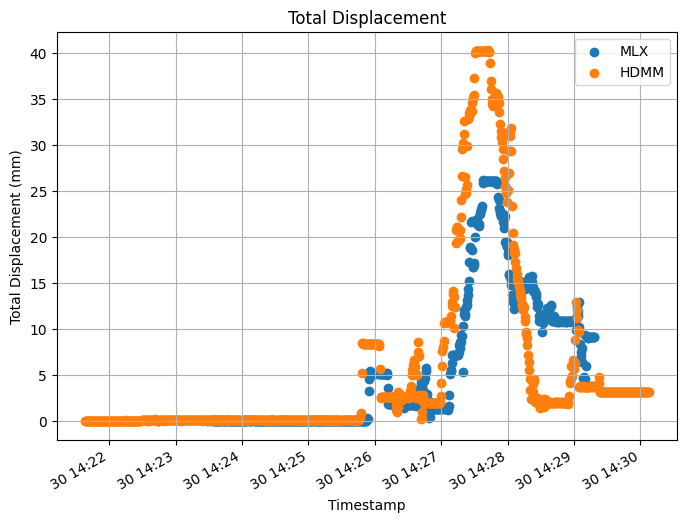

In [13]:
rel_loc_predx = [x - locpred[0,0] for x in locpred[:,0]]
rel_loc_predy = [x - locpred[0,1] for x in locpred[:,1]]
rel_loc_predz = [x - locpred[0,2] for x in locpred[:,2]]


dispx = np.array(rel_loc_predx)
dispy = np.array(rel_loc_predy)
dispz = np.array(rel_loc_predz)
disp = np.sqrt(dispx**2+dispy**2+dispz**2)

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(corrected_timestamps, disp, label='MLX')
plt.scatter(hdmm_time, hdmm_disp, label='HDMM')
#plt.scatter(hdmm_time[a:b], hdmm_disp2)
# Set x-axis labels to show only the time
# Format the x-axis to show date and time properly
plt.gcf().autofmt_xdate()  # Auto-format the dates on the x-axis
plt.xlabel('Timestamp')
plt.ylabel('Total Displacement (mm)')
plt.title('Total Displacement')
plt.legend()
plt.grid(True)
plt.show()

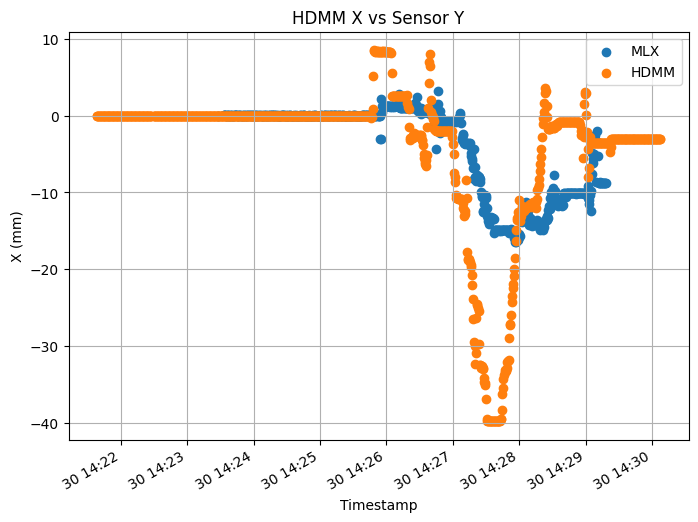

In [14]:
# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(corrected_timestamps, rel_loc_predy, label='MLX')
plt.scatter(hdmm_time, hdmm_x, label='HDMM')
plt.gcf().autofmt_xdate()  # Auto-format the dates on the x-axis
plt.xlabel('Timestamp')
plt.ylabel('X (mm)')
plt.title('HDMM X vs Sensor Y')
plt.grid(True)
plt.legend()
plt.show()

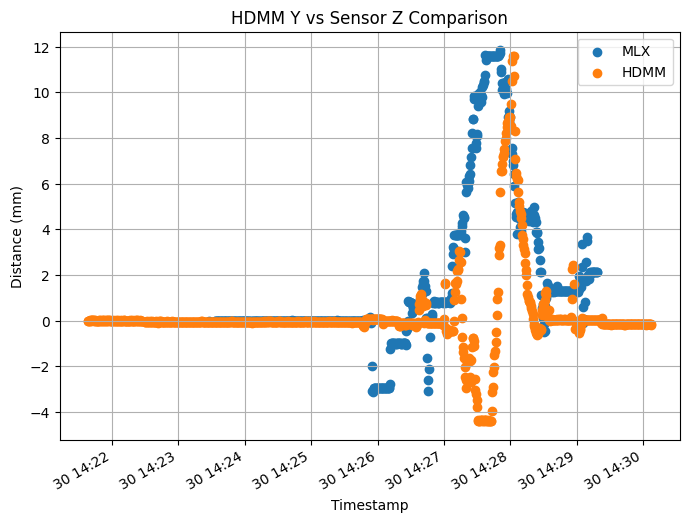

In [15]:
# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(corrected_timestamps, -np.array(rel_loc_predz), label='MLX')
plt.scatter(hdmm_time, hdmm_y, label='HDMM')
plt.gcf().autofmt_xdate()  # Auto-format the dates on the x-axis
plt.xlabel('Timestamp')
plt.ylabel('Distance (mm)')
plt.title('HDMM Y vs Sensor Z Comparison')
plt.grid(True)
plt.legend()
plt.show()

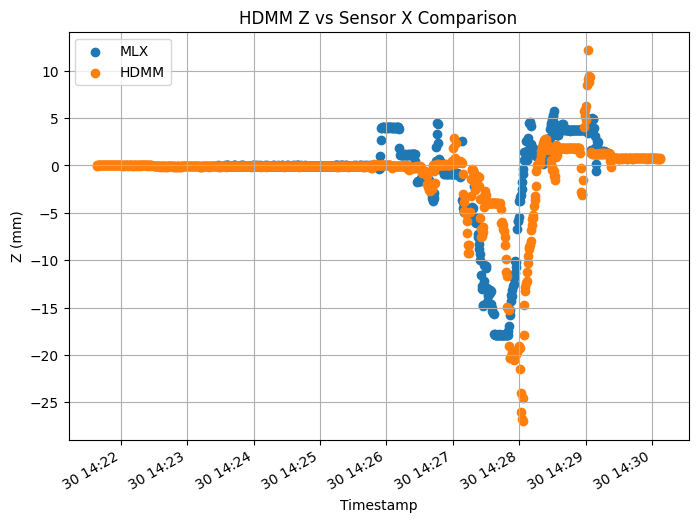

In [16]:
# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(corrected_timestamps, rel_loc_predx, label='MLX')
plt.scatter(hdmm_time, hdmm_z, label='HDMM')
plt.gcf().autofmt_xdate()  # Auto-format the dates on the x-axis
plt.xlabel('Timestamp')
plt.ylabel('Z (mm)')
plt.title('HDMM Z vs Sensor X Comparison')
plt.grid(True)
plt.legend()
plt.show()